# Spectra acquisiton
Control both the stepping motor and the camera from this notebook.<br>
Make a loop to measure a wide-range spectrum automatically.

NOTE: only one connection to COM port is possible at a time. Shut down other connections, either in python or dedicated software.

In [1]:
%pylab inline 
import time, os, logging
from FLI import FLI
import numpy as np
import xarray as xr
from os.path import join
%run thr640.py
%run imaging_tool.py
logger = logger
logger.setLevel(50) # 10 - DEBUG 50 - CRITICAL 20 - INFO
camera = FLI()
step_motor = THR640() # Can only have one instance.
                                
# basepath = r'\\10.249.254.51\Public\Kuzmin\Experiments-Leprecon\Spectrometer\20230106'
basepath = r'C:\Users\fujii\Documents\python\kuzmin\miura\20230122'
if not os.path.exists(basepath):
    os.makedirs(basepath)


Populating the interactive namespace from numpy and matplotlib


# Single

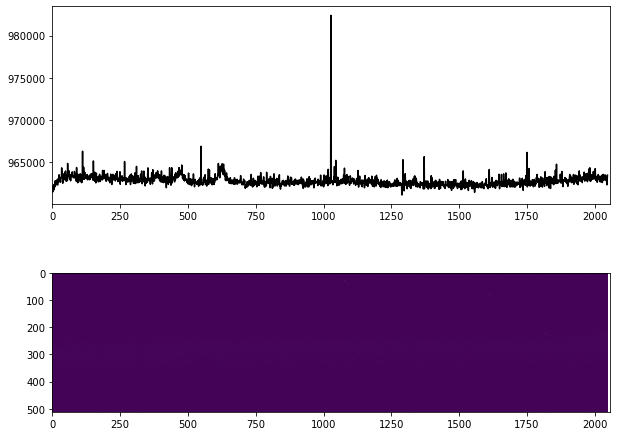

In [27]:
name=("30%6")
exposure = 300 * 1e3 # ms
tag=""
# count = 213000 # O777

# count = 411000 # H alpha
# count = 598000 # H beta
# count = 645000 # H gamma
# count = 740000 # OH 
count = 215000
hour=datetime.datetime.now().hour;minute=datetime.datetime.now().minute


step_motor.goto(count)
step_motor.waitUntilReady()
vbin = 1
attributes = {   
    "temperature": camera.getTemperature(),
    "device_status": camera.getDeviceStatus(),
    "exposure": exposure,
    "frame_type": "light",
}
camera.setExposureTime(exposure);camera.setVBin(vbin);camera.setImageArea(10,0,2058,512//vbin);camera.exposeFrame()
time.sleep(.1)
# load image
image_data = camera.grabFrame(out=np.empty((512//vbin,2048), np.uint16))
# convert to xarray
data = xr.DataArray(
    image_data, dims=["y", "x"], coords={"image_counter": 0}, attrs=attributes
)
# save data as NetCDF file
filepath = join(basepath,f'{name}-{count}-{exposure}ms-{tag}-{hour}{minute}.nc')
data.to_netcdf(filepath)
plot_image(image_data)

# LOOP

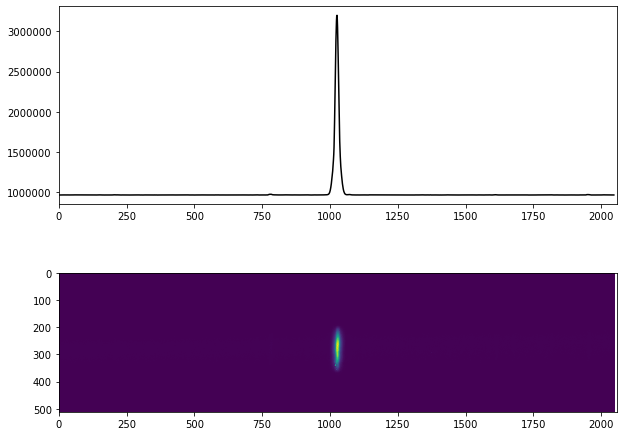

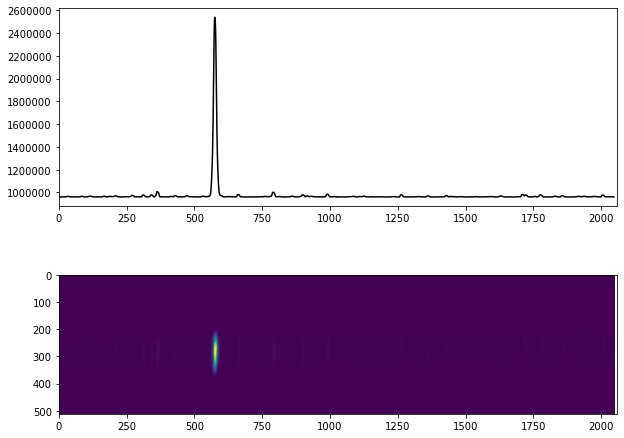

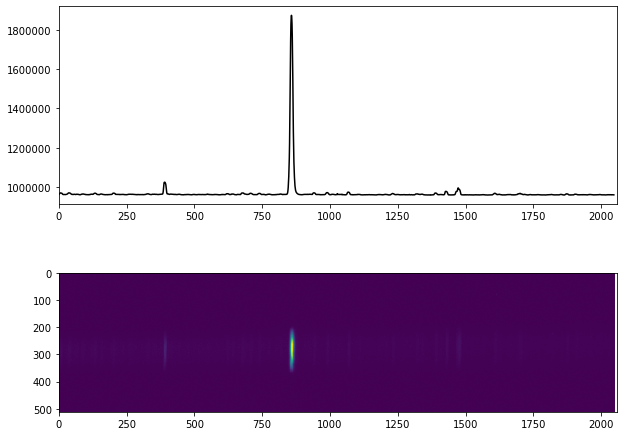

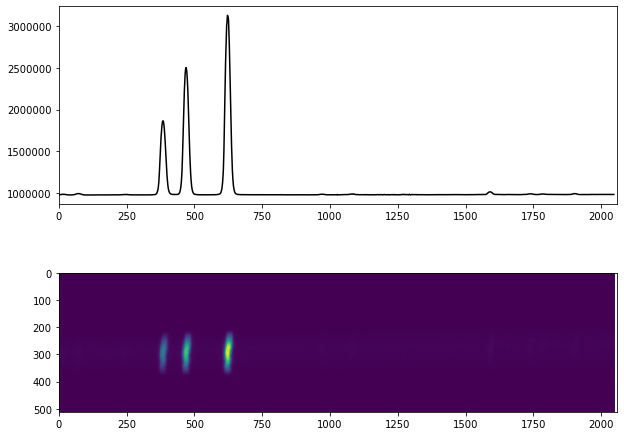

In [21]:
import mkse as mk
ccw_limit = 0
cw_limit = 1030000

name=("30%") 
tag=""
ampere = 2
# R = range(200000,805000,5000)
# R = [211000,212000,215000,216000]
# R = [199000,200000,210000,390000,400000,410000,575000, 585000, 595000]
# R = [180000,185000,195000]
R = [411000,598000,645000,215000]
T = [10e3,30e3,60e3,60e3]
# R = [215000] # filter
# T = [300e3] # filter
# R = [415000]
# T = [10e3]
# R = [(i+1)*5000 for i in range(200)]
# R = [420000]
# T = [60e3]*9
# T = [60e3]*6
# T = [10e3]*4 #H2onlyloop
# T = [100e3,50e3,50e3,50e3] #H2O2loop
# T = [10e3]*100
hour=datetime.datetime.now().hour;minute=datetime.datetime.now().minute

for i in range(len(R)):
    if ccw_limit < R[i] < cw_limit:
        step_motor.goto(R[i]);step_motor.waitUntilReady();vbin = 1
        attributes = {
            "temperature": camera.getTemperature(),
            "device_status": camera.getDeviceStatus(),
            "exposure": T[i],
            "frame_type": "light",
        }
        camera.setExposureTime(T[i]);camera.setVBin(vbin);camera.setImageArea(10,0,2058,512//vbin);camera.exposeFrame()
        time.sleep(.1)
        
        image_data = camera.grabFrame(out=np.empty((512//vbin,2048), np.uint16)) # load image
        data = xr.DataArray(image_data, dims=["y", "x"], coords={"image_counter": 0}, attrs=attributes) # convert to xarray
        plot_image(image_data)
        filepath = join(basepath,f'{name}-{R[i]}-{T[i]}ms-{ampere}A-{tag}-{hour}{minute}.nc')
        # filepath = join(basepath,f'{name}-{R[i]}-{T[i]}ms-{hour}{minute}-{tag}.nc')
        data.to_netcdf(filepath) # save data as NetCDF file
    else:
        print("out of range")
        break